# 演習・交通手段分類（機械学習）

## 教師あり

### 分類

交通手段をいくつかの特徴で分類します。

In [2]:
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# PLEASE REPLACE THE BELOW PATH WITH YOUR OWN
df = pd.read_csv('./traj_010_labeled_with_features.csv', index_col=0)
# create dataframe holding features per trip
# in this notebook, we focus on the features' mean scores per trip
df = df.groupby('trans_trip').agg({
    'distance': np.mean,
    'speed': np.mean,
    'accel': np.mean,
    'angle':np.mean,
    'angular_velocity':np.mean,
    'trans_mode':lambda x: pd.unique(x)[0],
})
df.head()

,distance,speed,accel,angle,angular_velocity,trans_mode
trans_trip,,,,,,
1.0,0.920653,55.720618,-0.014007,68.982383,0.354393,train
2.0,1.082321,65.670647,-0.001027,116.581851,0.568180,train
3.0,1.339320,74.683147,-0.003409,215.717754,0.480407,train
4.0,3.513432,173.776717,0.233277,174.470829,0.283810,train
5.0,4.282399,68.448484,-0.025508,150.209730,0.176290,train


In [5]:
# drop rows holding np.nan
df.dropna(inplace = True)

In [6]:
df.describe()

,distance,speed,accel,angle,angular_velocity
count,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.081362,39.136603,-0.068544,171.572185,24.004009
std,0.329114,38.591674,0.115817,64.819410,24.533810
min,0.001203,1.925925,-1.116834,5.303116,0.176290
25%,0.002057,6.276831,-0.108822,128.523012,2.852289
50%,0.009352,27.671732,-0.045742,173.816135,18.066445
75%,0.020917,53.299781,-0.006693,218.588914,35.412731
max,4.282399,175.182973,0.298885,329.530934,114.471672


In [7]:
# Let's check the counts of the target categorical values in the dataset
df.trans_mode.value_counts()

walk      152
train      99
taxi       96
subway     47
bus        34
Name: trans_mode, dtype: int64

In this notebook, we merge several labels and use three labels: vehicle(car/taxi/bus), walk, and train(train/subway).

In [8]:
# create a dictionary holding new labels as values and corresponding old labels as keys
trans_mode_map = {'bus':'vehicle', 'car':'vehicle','taxi':'vehicle','subway':'train', 'walk':'walk','train':'train'}
# map the above dictionary to the current labels and replace them with the three labels
df['trans_mode'] = df.trans_mode.map(trans_mode_map)
# count each labels
df.trans_mode.value_counts()

walk       152
train      146
vehicle    130
Name: trans_mode, dtype: int64

In [9]:
### implementation of some basic classificaition models

create `X` holding features to be used in models and `y` holding labels to be predicted.

In [10]:
X = df[['speed','accel','angular_velocity']]
y = df['trans_mode']

In [11]:
# check correlations between features
X.corr()

,speed,accel,angular_velocity
speed,1.000000,0.159520,-0.530622
accel,0.159520,1.000000,-0.068022
angular_velocity,-0.530622,-0.068022,1.000000


In [12]:
# check the sizes of X and y
X.shape, y.shape

((428, 3), (428,))

In [13]:
# Split into training and validation data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Run several classification models to estimate transportation mode (vehicle, train, and walk)

In this notebook, we run `logistic regression`, `SVM(support vector machines)`, and `Decision Tree` as examples. 
To understand how each model works, please check the documents below and other machine learning introductory materials.

logistic regression: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

SVM: https://scikit-learn.org/stable/modules/svm.html#support-vector-machines

Decision Tree: https://scikit-learn.org/stable/modules/tree.html#decision-trees

In [14]:
# Logistic regression models (one-vs-rest)
lg_model=LogisticRegression()
lg_model.fit(X_train, y_train) # Fitting models to training data
lg_y_predicted=lg_model.predict(X_test) # Predicting labels with test data.
# Assessment of prediction accuracy
print('accuracy score (w/ training data): {}'.format(lg_model.score(X_train, y_train)))
# Assessment of prediction accuracy
print('accuracy score (w/ validation data): {}'.format(lg_model.score(X_test, y_test)))
print(classification_report(y_test, lg_y_predicted))
# print out confusion matrix
pd.DataFrame(confusion_matrix(y_test, lg_y_predicted), 
             columns = ['train','vehicle','walk'], 
             index=['train','vehicle','walk'])

accuracy score (w/ training data): 0.9130434782608695
accuracy score (w/ validation data): 0.9069767441860465
              precision    recall  f1-score   support

       train       0.92      0.80      0.85        44
     vehicle       0.80      0.92      0.86        39
        walk       1.00      1.00      1.00        46

    accuracy                           0.91       129
   macro avg       0.91      0.91      0.90       129
weighted avg       0.91      0.91      0.91       129



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,train,vehicle,walk
train,35,9,0
vehicle,3,36,0
walk,0,0,46


In the above cell, we printed out the accuracy score within training data and those within validation data.

Also, we printed out the classification reports that hold more information, including precision, recall, and f1-score.

* $\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$
* $\texttt{precision} = tp / (tp + fp)$ where tp is tp (true positive) is the correct result and fp (false positive) is an unexpected result
* $\texttt{recall} =  tp / (tp + fn)$ where fn (false negative) is missing result
* $\texttt{f1-score} = 2 * (precision * recall) / (precision + recall)$

With the confusion matrix, we can easily check which label are misclassified to which.

In [15]:
# Support Vector Machine (SVM)
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train) 
svm_y_predicted=svm_clf.predict(X_test) # Predicting labels with test data.
print("accuracy score (w/ training data): ", svm_clf.score(X_train, y_train)) 
print("accuracy score (w/ validation data): ", svm_clf.score(X_test, y_test)) 
print(classification_report(y_test, svm_y_predicted))
# print out confusion matrix
pd.DataFrame(confusion_matrix(y_test, svm_y_predicted), 
             columns = ['train','vehicle','walk'], 
             index=['train','vehicle','walk'])

accuracy score (w/ training data):  0.919732441471572
accuracy score (w/ validation data):  0.875968992248062
              precision    recall  f1-score   support

       train       0.92      0.82      0.87        44
     vehicle       0.79      0.79      0.79        39
        walk       0.90      1.00      0.95        46

    accuracy                           0.88       129
   macro avg       0.87      0.87      0.87       129
weighted avg       0.88      0.88      0.87       129



,train,vehicle,walk
train,36,8,0
vehicle,3,31,5
walk,0,0,46


In [16]:
# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=0, max_depth=3)
tree_clf.fit(X_train, y_train) 
tree_y_predicted=tree_clf.predict(X_test)
print("accuracy score (w/ training data): ", tree_clf.score(X_train, y_train)) 
print("accuracy score (w/ validation data): ",tree_clf.score(X_test, y_test))
print(classification_report(y_test, tree_y_predicted))
# print out confusion matrix
pd.DataFrame(confusion_matrix(y_test, tree_y_predicted), 
             columns = ['train','vehicle','walk'], 
             index=['train','vehicle','walk'])

accuracy score (w/ training data):  0.9431438127090301
accuracy score (w/ validation data):  0.9302325581395349
              precision    recall  f1-score   support

       train       0.89      0.91      0.90        44
     vehicle       0.89      0.87      0.88        39
        walk       1.00      1.00      1.00        46

    accuracy                           0.93       129
   macro avg       0.93      0.93      0.93       129
weighted avg       0.93      0.93      0.93       129



,train,vehicle,walk
train,40,4,0
vehicle,5,34,0
walk,0,0,46


Let's visualize how the tree classifes our data

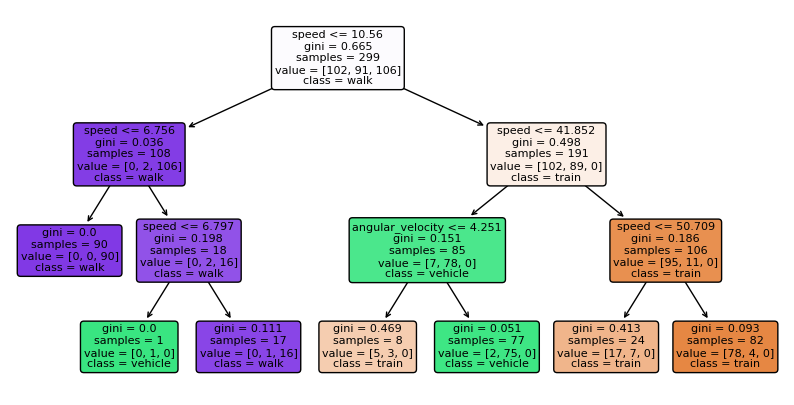

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
tree.plot_tree(
    tree_clf, ax = ax, fontsize=8, 
    feature_names= X.columns,  
    class_names= y.unique(), 
    filled=True,
    rounded=True,
)
plt.show()

## 教師なし

ここでは`K-means`と`PCA`を用います

* K-means: https://scikit-learn.org/stable/modules/clustering.html#k-means
* PCA: https://scikit-learn.org/stable/modules/decomposition.html#pca


### K-means

ここでは、特徴量 `angular_velocity` と `speed` を用いて、K-means を用いてクラスタリングを行います。
K-meansでは、クラスタの数を指定する必要があるので、ここでは2つのクラスタを生成します。

In [18]:
X_kmeans = df[['angular_velocity', 'speed']]
model = KMeans(n_clusters=3) # with n_clusters specifying the number of clusters
model.fit(X_kmeans) # fitting the data
y_km=model.predict(X_kmeans) # predict clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


正解データとクラスタリングの結果を比較してみます

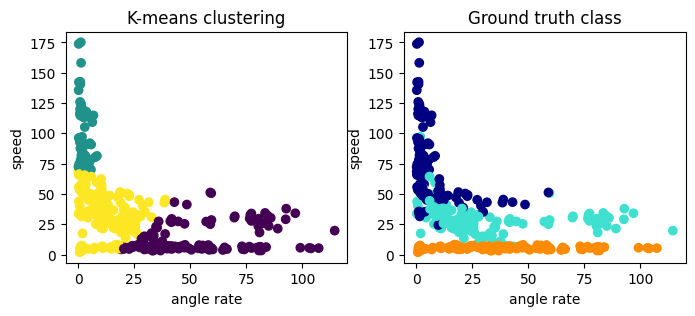

In [19]:
y = df['trans_mode']
y_colors = y.map({'train':'navy', 'vehicle':'turquoise', 'walk':'darkorange'}) 
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, ax in enumerate(axs):
    ax.scatter(df['angular_velocity'], df['speed'], c = [y_km, y_colors][i])
    ax.set_xlabel('angle rate')
    ax.set_ylabel('speed')
    ax.set_title(['K-means clustering', 'Ground truth class'][i])
plt.show()

2つの特徴量しか用いていないこともあり、K-meanではあまりうまく分類ができていないですが、それでも大まかな傾向は捉えているようです。

#### PCA (Principal Component Analysis)

高次元データの次元削減のために用いられることが多いです。
ここでは、GPS軌跡データの5つの特徴量をPCAを用いて2次元に縮小します。

In [20]:
X_pca = df[['distance','speed','accel','angle','angular_velocity']]
y = df['trans_mode']

In [21]:
X_pca = StandardScaler().fit_transform(X_pca)

In [22]:
pca = PCA(n_components=2)
X_pca_res = pca.fit_transform(X_pca)

In [25]:
print(pca.explained_variance_ratio_)

[0.36113444 0.2130784 ]


第1主成分と第2主成分をプロットします。

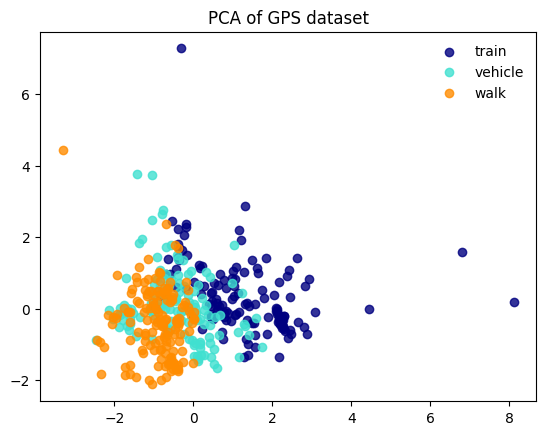

In [26]:
colors = ['navy', 'turquoise', 'darkorange']
target_names =  y.unique()
for color, target_name in zip(colors, target_names):
    plt.scatter(X_pca_res[y == target_name, 0], X_pca_res[y == target_name, 1], color=color, alpha=.8, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, frameon=False)
plt.title('PCA of GPS dataset')
plt.show()